Add some points to the skin efficiency figure by reducing the ansatz a little. Specifically, I will remove the mixed term Psi_I4a_I4s etc in this notebook to reduce the number of parameters

In [1]:
import jax.numpy as np
import numpy as onp
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
import pandas as pd
config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Train NODE, CANN, ICNN, MFNN, directly against rubber stress data

Train directly against the stress data from the three rubber datasets.
Note. I wanted to do these four different schemes. the last one I wanted to do was this MF scheme where I would combine a CANN with a NODE but that doesnt seem necessary in that the CANN and the NODE alone can do just fine for rubber data. So at least for rubber doesnt seem necessary. 

In [2]:
## Doing with an object 'model' I still like that 
def eval_Cauchy(lambx,lamby, model, norm):
    # all norm constants 
    I1_factor, I2_factor, I4a_factor, I4s_factor, Psi1_factor, Psi2_factor, Psi_1_4a_factor, Psi_1_4s_factor = norm
    I1 = lambx**2+lamby**2+(1./(lambx*lamby)**2)
    I2 = lambx**2*lamby**2 + lambx**2*(1./(lambx*lamby)**2) + lamby**2*(1./(lambx*lamby)**2) 
    I4a = lambx**2
    I4s = lamby**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    I4anorm = (I4a-1)/I4a_factor
    I4snorm = (I4s-1)/I4s_factor
    # calling all the NODE predictions and undoing normalization 
    # single variable terms 
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    
    Psi_1_4a = model.Psi_1_4a_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_4a_1 = model.Psi_4a_1_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_1_4s = model.Psi_1_4s_norm(I1norm,I4snorm)*Psi_1_4s_factor
    Psi_4s_1 = model.Psi_4s_1_norm(I1norm,I4snorm)*Psi_1_4s_factor
    
    Psi1 = Psi1+0.0+Psi_4a_1+Psi_4s_1
    Psi2 = Psi2+0.0+0.0+0.0
    Psi4a = Psi_1_4a
    Psi4s = Psi_1_4s
    # get pressure from sigma_33 = 0 
    lambz = 1./(lambx*lamby)
    p = Psi1*lambz**2 + Psi2*(I1*lambz**2 - lambz**4) 
    sigx = Psi1*lambx**2 + Psi2*(I1*lambx**2 - lambx**4) + Psi4a*lambx**2 - p
    sigy = Psi1*lamby**2 + Psi2*(I1*lamby**2 - lamby**4) + Psi4s*lamby**2 - p
    return sigx,sigy

def plotstresses(x_gt,sgmx_gt,sgmy_gt,x_pr,sgmx_pr, sgmy_pr):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    labels = ['UT', 'ET', 'PS']
    for axi, x_gti, sgmx_gti, sgmy_gti, x_pri, sgmx_pri, sgmy_pri, label in zip(ax, x_gt, sgmx_gt, sgmy_gt, x_pr, sgmx_pr, sgmy_pr, labels):
        axi.plot(x_gti, sgmx_gti, 'k.')
        axi.plot(x_pri, sgmx_pri, 'k-')
    
        axi.plot(x_gti, sgmy_gti, 'b.')
        axi.plot(x_pri, sgmy_pri, 'b-')

        axi.set_title(label)
        axi.set_xlabel(r'Stretch $\lambda [-]$')
        axi.set_ylabel(r'Cauchy stress $\sigma [MPa]$')
    return fig, ax

In [3]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2, params_I1_I4a, params_I1_I4s):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
    
    def Psi1norm(self, I1norm):
        return NODE_vmap(I1norm, self.params_I1)
    
    def Psi2norm(self, I2norm):
        return NODE_vmap(I2norm, self.params_I2)
    
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        return alpha*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        return alpha*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4s[:-1])

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2, params_I1_I4a, params_I1_I4s,norm):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.norm = norm
        
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the sigma functions expect the gradient so taking derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.norm[0]
    
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.norm[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*alpha/self.norm[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*(1-alpha)/self.norm[2]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*alpha/self.norm[0]
    
    # mixed term with I4s and I1
    # output is derivative wrt I4s
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*(1-alpha)/self.norm[3]
    

class CANN_model():
    def __init__(self, params_I1, params_I2, params_I1_I4a, params_I1_I4s,norm):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.norm = norm
    
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/self.norm[0]
    
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/self.norm[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*alpha/self.norm[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*(1-alpha)/self.norm[2]
    
    # mixed term with I4s and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*alpha/self.norm[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*(1-alpha)/self.norm[3]
    

In [4]:
I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor, I2_factor, I4a_factor, I4s_factor, Psi1_factor, Psi2_factor, Psi_1_4a_factor, Psi_1_4s_factor]

@partial(jit, static_argnums=(2,))
def loss_sig_all(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:,0]
    lamby = lamb_sigma[:,1]
    sigmax = lamb_sigma[:,2]
    sigmay = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_e(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:ind_sx,0]
    lamby = lamb_sigma[:ind_sx,1]
    sigmax = lamb_sigma[:ind_sx,2]
    sigmay = lamb_sigma[:ind_sx,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sx(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sx:ind_sy,0]
    lamby = lamb_sigma[ind_sx:ind_sy,1]
    sigmax = lamb_sigma[ind_sx:ind_sy,2]
    sigmay = lamb_sigma[ind_sx:ind_sy,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sy(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(*params,normalization)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sy:,0]
    lamby = lamb_sigma[ind_sy:,1]
    sigmax = lamb_sigma[ind_sy:,2]
    sigmay = lamb_sigma[ind_sy:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(0,1,))
def step_jp(loss, mdlnumber, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, mdlnumber)
    return opt_update(i, g, opt_state)

def train_jp(loss, mdlnumber, X, opt_state, key, nIter = 10000, print_freq=1000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, mdlnumber, it, opt_state, X)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, mdlnumber)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

In [5]:
def init_node(key, layers=[1,5,5,1]):
    key, subkey = random.split(key)
    params_I1 = init_params(layers, key)
    params_I2 = init_params(layers, key)
    params_I1_I4a = init_params(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params(layers, key)
    params_I1_I4s.append(0.5)
    return [params_I1, params_I2, params_I1_I4a, params_I1_I4s], key

def init_icnn(key, layers=[1,4,3,1]):
    key, subkey = random.split(key)
    params_I1 = init_params_icnn(layers, key)
    params_I2 = init_params_icnn(layers, key)
    params_I1_I4a = init_params_icnn(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_icnn(layers, key)
    params_I1_I4s.append(0.5)

    return [params_I1,params_I2, params_I1_I4a, params_I1_I4s], key

def init_cann(key, layers=None): #n params = 50
    key, subkey = random.split(key)
    params_I1 = init_params_cann(key)
    params_I2 = init_params_cann(key)
    params_I1_I4a = init_params_cann(key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_cann(key)
    params_I1_I4s.append(0.5)

    return [params_I1,params_I2, params_I1_I4a, params_I1_I4s], key

In [16]:
def n_params_node(layers=[1,5,5,1]):
    n = 0
    for i in range(len(layers)-1):
        n+= layers[i]*layers[i+1]
    return n*4+2 #5 Neural networks and 3 scalars

def n_params_icnn(layers=[1,4,3,1]):
    n = 0
    n += layers[0]*layers[1] + layers[1]
    for i in range(1,len(layers)-1):
        n+= layers[i]*layers[i+1] #Wz
        n+= layers[0]*layers[i+1] #Wy
        n+= layers[i+1] #b
    return n*4+2 #5 Neural networks and 11 scalars

# Find optimal architecture for a given n_params
def opt_arch_node(n): # return the "sorta" best architecture given # of parameters
    archs = [[1,1,1],[1,2,1],[1,3,1],[1,2,2,1],[1,2,3,1],[1,3,3,1],[1,3,4,1],[1,4,4,1],[1,5,5,1],[1,4,4,4,1],[1,5,5,5,1]]
    m = onp.array([10, 18, 26, 34, 46, 62, 78, 98, 142, 162, 242])

    idx = (onp.abs(m-n)).argmin()

    return m[idx], archs[idx]


def opt_arch_icnn(n): # return the "sorta" best architecture given # of parameters
    archs = [[1,1,1],[1,2,1],[1,3,1],[1,4,1],[1,2,2,1],[1,2,3,1],[1,3,3,1],[1,4,4,1],[1,5,5,1],[1,4,4,4,1],[1,5,5,5,1]]
    m = onp.array([22, 34, 46, 58, 66, 86, 106, 154, 210, 250, 350])

    idx = (onp.abs(m-n)).argmin()
    
    return m[idx], archs[idx]

## 50 runs

In [13]:
with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb = lamb.astype(np.float64)
sigma = sigma.astype(np.float64)
ind_sx = 81
ind_sy = 182
lamb_sigma = np.hstack([lamb,sigma])
ind_all = 254

### CANN

In [14]:
loss_fns = [loss_sig_sx, loss_sig_e, loss_sig_sy, loss_sig_all]
loads = ['SX', 'EB', 'SY', 'ALL']
for loss_fn, load in zip(loss_fns, loads):
    r2_list = []
    mae_list = []
    for i in range(10): #50 runs for every architecture
        key, subkey = random.split(key)
        params, _ = init_cann(key)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
        opt_state = opt_init(params)
        mdlnumber = 1
        params, train_loss, val_loss = train_jp(loss_fn, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000, print_freq=100000)
        model = CANN_model(*params, normalization)
        with open('savednet/skin_efficiency/CANN_params_'+load+'_red1_'+str(i)+'.npy', 'wb') as f:
            pickle.dump(params, f)

        indices = [[ind_sx,ind_sy], [0,ind_sx], [ind_sy, ind_all]]

        r2 = []
        mae = []
        for [i1,i2] in indices:
            lm_x = lamb_sigma[i1:i2,0]
            lm_y = lamb_sigma[i1:i2,1]
            sgmx_gt = lamb_sigma[i1:i2,2]
            sgmy_gt = lamb_sigma[i1:i2,3]
            Px_gt = sgmx_gt/lm_x
            Py_gt = sgmy_gt/lm_y

            sgmx_pr, sgmy_pr = eval_Cauchy(lm_x, lm_y, model, normalization)
            Px_pr = sgmx_pr/lm_x
            Py_pr = sgmy_pr/lm_y

            r2_x = r2_score(Px_gt, Px_pr)
            r2_y = r2_score(Py_gt, Py_pr)
            r2_x = np.clip(r2_x, a_min=0.0, a_max=1.0)
            r2_y = np.clip(r2_y, a_min=0.0, a_max=1.0)

            r2i = 0.5*(r2_x + r2_y)
            r2.append(r2i)

            maei = onp.mean(onp.abs(Px_gt-Px_pr) + onp.abs(Py_gt-Py_pr))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        print(*mae)
        r2_list.append(r2)
        mae_list.append(mae)
    cann_r2 = np.array(r2_list)
    cann_mae = np.array(mae_list)

    with open('savednet/CANN_skin_r2_efficiency_'+load +'_red1.npy', 'wb') as f:
        pickle.dump([[50], cann_r2], f)
    with open('savednet/CANN_skin_mae_efficiency_'+load +'_red1.npy', 'wb') as f:
        pickle.dump([[50], cann_mae], f)

0.004060378613138115 0.0664182802783469 0.10508474529270827
0.004060435498798659 0.06631200299258339 0.10501130551896593
0.004060335899821074 0.0663606790999839 0.1050454706600421
0.004060498681692856 0.06648215294196742 0.10512317289605531
0.00406072494788039 0.06633328339427465 0.10502525530882197
0.0025795777437356317 5.085119180203506 6.3096508374203735
0.002579842368531061 5.214305788349766 6.559824169362927
0.0025789133892800413 5.078440326769192 6.3118620109849575
0.0025757706810446623 5.103215550646278 6.334157077855981
0.0025816645062328903 4.979002220282256 6.167343471761995
0.01897117784105567 0.0026613311993648895 0.04474092396581724
0.018994992766434945 0.0026617369365825733 0.044740538066235555
0.018965173086945657 0.0026624925362752692 0.04474110917345954
0.018977909453660693 0.0026620312627823168 0.04474092283994323
0.01897152482649247 0.0026612875881710293 0.044742600428846466
0.018968527115436905 0.002661565701135891 0.04474115788721185
0.018963675537094733 0.00266207

### NODE

In [17]:
loss_fns = [loss_sig_sx, loss_sig_e, loss_sig_sy, loss_sig_all]
loads = ['SX', 'EB', 'SY', 'ALL']
for loss_fn, load in zip(loss_fns, loads):
    np_list = []
    r2_list_global = []
    mae_list_global = []
    for n in range(10,18):
        n_params, layers = opt_arch_node(n)
        if n_params in np_list:
            continue
        print(n_params, layers)
        np_list.append(n_params)

        r2_list_arch = []
        mae_list_arch = []
        for i in range(10): #50 runs for every architecture
            key, subkey = random.split(key)
            params, _ = init_node(key, layers)

            opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
            opt_state = opt_init(params)
            mdlnumber = 3
            params, train_loss, val_loss = train_jp(loss_fn, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000, print_freq=100000)
            model = NODE_model(*params)
            with open('savednet/skin_efficiency/NODE_params_'+load+'_red1_'+str(n_params)+'params_'+str(i)+'.npy', 'wb') as f:
                pickle.dump(params, f)

            indices = [[ind_sx,ind_sy], [0,ind_sx], [ind_sy, ind_all]]

            r2 = []
            mae = []
            for [i1,i2] in indices:
                lm_x = lamb_sigma[i1:i2,0]
                lm_y = lamb_sigma[i1:i2,1]
                sgmx_gt = lamb_sigma[i1:i2,2]
                sgmy_gt = lamb_sigma[i1:i2,3]
                Px_gt = sgmx_gt/lm_x
                Py_gt = sgmy_gt/lm_y

                sgmx_pr, sgmy_pr = eval_Cauchy(lm_x, lm_y, model, normalization)
                Px_pr = sgmx_pr/lm_x
                Py_pr = sgmy_pr/lm_y

                r2_x = r2_score(Px_gt, Px_pr)
                r2_y = r2_score(Py_gt, Py_pr)
                r2_x = np.clip(r2_x, a_min=0.0, a_max=1.0)
                r2_y = np.clip(r2_y, a_min=0.0, a_max=1.0)

                r2i = 0.5*(r2_x + r2_y)
                r2.append(r2i)

                maei = onp.mean(onp.abs(Px_gt-Px_pr) + onp.abs(Py_gt-Py_pr))
                mae.append(maei)
            # r2 = np.mean(np.array(r2))
            # print(*r2)
            print(*mae)
            r2_list_arch.append(r2)
            mae_list_arch.append(mae)
        r2_list_global.append(r2_list_arch)
        mae_list_global.append(mae_list_arch)
    node_r2 = np.array(r2_list_global)
    node_mae = np.array(mae_list_global)

    with open('savednet/NODE_skin_r2_efficiency_'+load +'_red1.npy', 'wb') as f:
        pickle.dump([np_list, node_r2], f)
    with open('savednet/NODE_skin_mae_efficiency_'+load +'_red1.npy', 'wb') as f:
        pickle.dump([np_list, node_mae], f)

10 [1, 1, 1]
0.009631558120449796 0.040046729759876276 0.07015560237752724
0.009631167808891665 0.04006005599879149 0.0702001582272903
0.009623594117019824 0.04024755516663868 0.07084829689031892
0.009629893482486463 0.04015980969326697 0.07046253964407821
0.009637405628139776 0.039793362673232545 0.06931780904903057
0.009632727526297093 0.04001450910882279 0.07005859005151767
0.009627811699498591 0.04013756614618993 0.07048271020085702
0.009634385041655551 0.0399983833441038 0.07000842107877513
0.00962361601881222 0.04039465796488377 0.07129679300561241
0.009636472198219167 0.03983715792163546 0.06946314286857357
18 [1, 2, 1]
0.009609977246458188 0.04064455893138648 0.07218795119715644
0.008217867149298902 0.03980070900469014 0.07275053956949226
0.009604640486877203 0.040331782213525035 0.07115426179606968
0.00960480931979436 0.04064734879402895 0.07207592037697015
0.009608234176121909 0.04065726472696165 0.07218733685396243
0.009610126726104553 0.04047312779914078 0.07167188712771419

### ICNN

In [18]:
loss_fns = [loss_sig_sx,    loss_sig_e, loss_sig_sy,    loss_sig_all]
loads    = ['SX',           'EB',       'SY',           'ALL']
for loss_fn, load in zip(loss_fns, loads):
    np_list = []
    r2_list_global = []
    mae_list_global = []
    for n in range(22,23):
        n_params, layers = opt_arch_icnn(n)
        if n_params in np_list:
            continue
        print(n_params, layers)
        np_list.append(n_params)

        r2_list_arch = []
        mae_list_arch = []
        for i in range(10): #50 runs for every architecture
            key, subkey = random.split(key)
            params, _ = init_icnn(key, layers)

            opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
            opt_state = opt_init(params)
            mdlnumber = 2
            params, train_loss, val_loss = train_jp(loss_fn, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000, print_freq=100000)
            with open('savednet/skin_efficiency/ICNN_params_'+load+'_red1_'+str(n_params)+'params'+str(i)+'.npy', 'wb') as f:
                pickle.dump(params, f)
            model = ICNN_model(*params, normalization)

            indices = [[ind_sx,ind_sy], [0,ind_sx], [ind_sy, ind_all]]

            r2 = []
            mae = []
            for [i1,i2] in indices:
                lm_x = lamb_sigma[i1:i2,0]
                lm_y = lamb_sigma[i1:i2,1]
                sgmx_gt = lamb_sigma[i1:i2,2]
                sgmy_gt = lamb_sigma[i1:i2,3]
                Px_gt = sgmx_gt/lm_x
                Py_gt = sgmy_gt/lm_y

                sgmx_pr, sgmy_pr = eval_Cauchy(lm_x, lm_y, model, normalization)
                Px_pr = sgmx_pr/lm_x
                Py_pr = sgmy_pr/lm_y

                r2_x = r2_score(Px_gt, Px_pr)
                r2_y = r2_score(Py_gt, Py_pr)
                r2_x = np.clip(r2_x, a_min=0.0, a_max=1.0)
                r2_y = np.clip(r2_y, a_min=0.0, a_max=1.0)

                r2i = 0.5*(r2_x + r2_y)
                r2.append(r2i)

                maei = onp.mean(onp.abs(Px_gt-Px_pr) + onp.abs(Py_gt-Py_pr))
                mae.append(maei)
            # r2 = np.mean(np.array(r2))
            # print(*r2)
            print(*mae)
            r2_list_arch.append(r2)
            mae_list_arch.append(mae)
        r2_list_global.append(r2_list_arch)
        mae_list_global.append(mae_list_arch)

    icnn_r2 = np.array(r2_list_global)
    icnn_mae = np.array(mae_list_global)

    with open('savednet/ICNN_skin_r2_efficiency_'+load+'_red1.npy', 'wb') as f:
        pickle.dump([np_list, icnn_r2], f)
    with open('savednet/ICNN_skin_mae_efficiency_'+load+'_red1.npy', 'wb') as f:
        pickle.dump([np_list, icnn_mae], f)

22 [1, 1, 1]
0.011601889888080138 0.20291391644620493 0.21510154605297144
0.004994024749659648 0.11283954591096743 0.15717475993663305
0.005595632281068326 0.11173032382304848 0.15777803895802253
0.01124526368196585 0.09809471550337162 0.1418147729788007
0.005478237096761811 0.09417896073632397 0.13459609160358468
0.005331363184390184 0.11242704814199944 0.15721275858466244
0.0058081957258235475 0.11197834584836028 0.15736472307893645
0.011702731886329462 0.08786076741808786 0.13373539720490976
0.0026440273028298096 0.08905556598546992 0.13902030380496924
0.006206788981836053 0.0948229852425442 0.13528939062950063
22 [1, 1, 1]
0.21133307245534652 0.018118104407137976 0.13504804322468544
0.8905972402654279 0.0054950330430037254 0.698698235932603
1.0035387045129742 0.004525409710916615 0.7189737057850818
0.05659866469707387 0.0029828754608061774 0.07086572084647001
0.026777236506365314 0.003524051065311979 0.027700343646393618
0.05610382831661906 0.021788224398265284 0.0725266819478568
0

In [19]:
def reject_outliers(data):
    mean = np.mean(data)
    stdv = np.std(data)
    test = np.abs(data-mean)<2*stdv
    return data[np.where(test)]

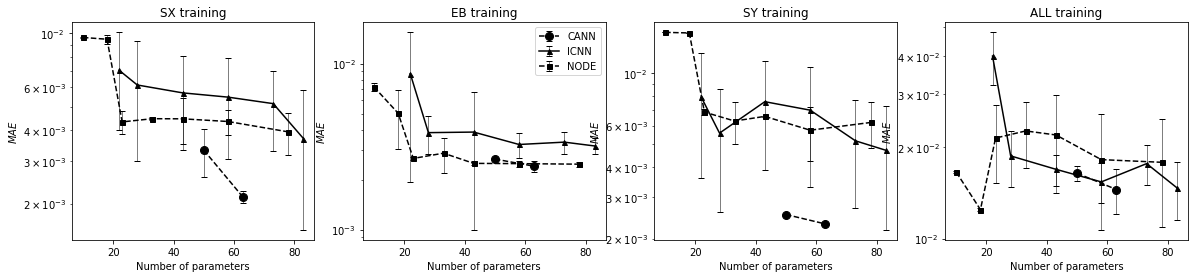

In [22]:
fig, axes = plt.subplots(1,4,figsize=(20,4))

loads = ['SX', 'EB', 'SY', 'ALL']
panels = ['a', 'b', 'c', 'd']
for i, (ax, load, panel) in enumerate(zip(axes, loads, panels)):
    models  = ['CANN',  'ICNN', 'NODE']
    markers = ['o--',     '^-',   's--' ]
    for model, marker in zip(models, markers):
        with open('savednet/'+model+'_skin_mae_efficiency_' + load + '_red1.npy', 'rb') as f:
            np_list1, mae1 = pickle.load(f)
        with open('savednet/'+model+'_skin_mae_efficiency_' + load + '.npy', 'rb') as f:
            np_list2, mae2 = pickle.load(f)
        np_list = np_list1 + np_list2
        mae = np.vstack([mae1,mae2])
        if model=='CANN':
            mae = mae.reshape([2,-1,3])
            ms = 8
            np_list = [50,63]
        else:
            ms = 5

        if load == 'ALL':
            mae = np.mean(mae, axis=2) #In the case of 'all' take average of all 3 load cases
        else:
            mae = mae[:,:,i] #Otherwise just take the training load case

        mae_new = []
        mean_trn = []
        stdv_trn = []
        for data in mae:
            # mae_new = reject_outliers(data) #either comment out this line or the next one
            mae_new = data 
            mean_trn.append(onp.mean(mae_new))
            stdv_trn.append(onp.std(mae_new))
        
        ax.errorbar(np_list, mean_trn, stdv_trn, elinewidth=0.5, capsize=3.0, fmt=marker, color='k', label=model, markersize=ms)

        # # Save for TikZ
        # np_list = onp.array(np_list)
        # mean_trn = onp.array(mean_trn)
        # stdv_trn = onp.array(stdv_trn)
        # errorp = stdv_trn
        # errorm = onp.min(onp.array([stdv_trn, mean_trn]), axis=0) - 1.e-9 # this is to make sure the lower bound of the error bar is not negative in log plots
        # data = onp.array([np_list, mean_trn*1000, errorp*1000, errorm*1000])
        # data = data.reshape([4,-1])
        # columns = ['x', 'y', 'error+', 'error-']
        # df = pd.DataFrame(data.T, columns=columns)
        # df.to_csv('TikZ/fig_skin_eff_data/'+model+'_'+panel+'.csv', index=False, sep = ' ')
    ax.set(xlabel='Number of parameters', ylabel='$MAE$', title=load + ' training', yscale='log')
axes[1].legend()
# fig.savefig('Figures/fig_skin_efficiency_mae_trnonly.jpg')

Test that everything is in order

Model params:  [[array([[-3.53259224, -6.35350415]]), array([[ 2.84256167],
       [-1.52566499]])], [array([[ 0.79953539, -3.88750134]]), array([[-0.86993132],
       [ 2.58965332]])], [array([[-1.12090081, -0.02153466]]), array([[-3.5657054 ],
       [-1.98136223]]), array(1.05862085)], [array([[-3.33170885, -5.2703177 ]]), array([[-3.48143748],
       [ 2.21049319]]), array(0.24617276)]]
Mean MAE of all 3 panels =  0.012671629461104889


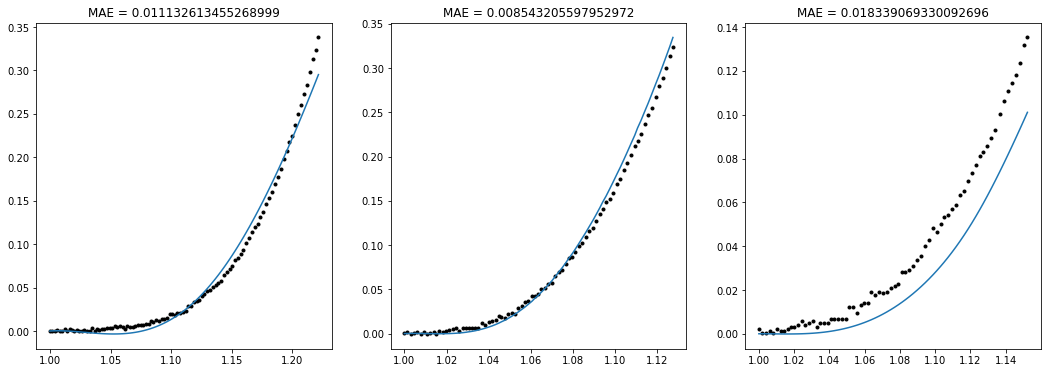

In [30]:
load = 'ALL'
n_params = 18
i = 0
with open('savednet/skin_efficiency/NODE_params_'+load+'_red1_'+str(n_params)+'params_'+str(i)+'.npy', 'rb') as f:
    params = pickle.load(f)
params_I1, params_I2, params_I1_I4a, params_I1_I4s = params
print('Model params: ', params)
model = NODE_model(*params)

indices = [[ind_sx,ind_sy], [0,ind_sx], [ind_sy, ind_all]]
xaxisvar = [0,0,1]
fig, axes = plt.subplots(1,3,figsize=(18,6))

maes = []
for ax,[i1,i2], lmid in zip(axes, indices, xaxisvar):
    lm_x = lamb_sigma[i1:i2,0]
    lm_y = lamb_sigma[i1:i2,1]
    sgmx_gt = lamb_sigma[i1:i2,2]
    sgmy_gt = lamb_sigma[i1:i2,3]
    Px_gt = sgmx_gt/lm_x
    Py_gt = sgmy_gt/lm_y

    sgmx_pr, sgmy_pr = eval_Cauchy(lm_x, lm_y, model, normalization)
    Px_pr = sgmx_pr/lm_x
    Py_pr = sgmy_pr/lm_y

    x = [lm_x, lm_y][lmid]
    mae = np.mean(np.abs(Px_gt-Px_pr) + np.abs(Py_gt-Py_pr))
    maes.append(mae)
    ax.plot(x, Px_gt, 'k.')
    ax.plot(x, Px_pr)
    ax.set(title='MAE = ' + str(mae))
mean_mae = np.mean(np.array(maes))
print("Mean MAE of all 3 panels = ", mean_mae)

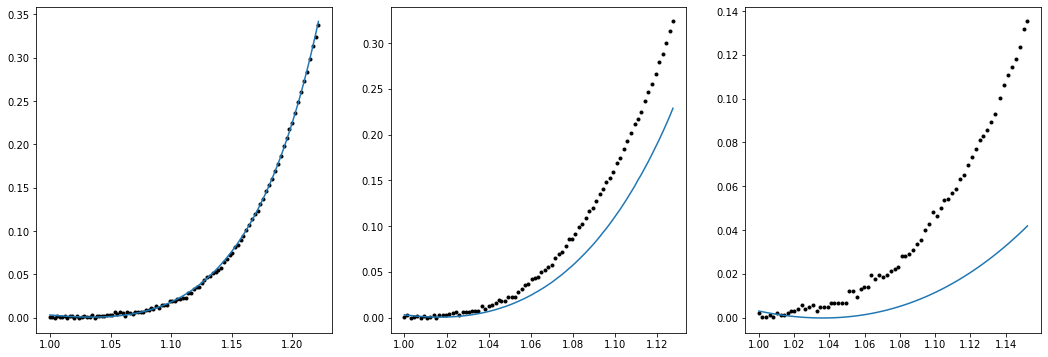

In [28]:
load = 'SX'
n_params = 28
i = 0
with open('savednet/skin_efficiency/ICNN_params_'+load+'_'+str(n_params)+'params'+str(i)+'.npy', 'rb') as f:
    params = pickle.load(f)
params_I1, params_I2, params_I1_I4a, params_I1_I4s, params_I4a_I4s = params
model = ICNN_model(*params, normalization)

indices = [[ind_sx,ind_sy], [0,ind_sx], [ind_sy, ind_all]]
xaxisvar = [0,0,1]
fig, axes = plt.subplots(1,3,figsize=(18,6))

for ax,[i1,i2], lmid in zip(axes, indices, xaxisvar):
    lm_x = lamb_sigma[i1:i2,0]
    lm_y = lamb_sigma[i1:i2,1]
    sgmx_gt = lamb_sigma[i1:i2,2]
    sgmy_gt = lamb_sigma[i1:i2,3]
    Px_gt = sgmx_gt/lm_x
    Py_gt = sgmy_gt/lm_y

    sgmx_pr, sgmy_pr = eval_Cauchy(lm_x, lm_y, model, normalization)
    Px_pr = sgmx_pr/lm_x
    Py_pr = sgmy_pr/lm_y

    x = [lm_x, lm_y][lmid]
    ax.plot(x, Px_gt, 'k.')
    ax.plot(x, Px_pr)